In [1]:
import numpy as np
import pandas as pd

from scipy import polyval, stats
import math
from statsmodels.graphics.mosaicplot import mosaic
import statsmodels.formula.api as sf
import statsmodels.api as sm

import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

from collections import Counter

In [2]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams["font.family"] = "sans-serif"

In [3]:
df = pd.read_csv("../Tasks/Barcelona airbnb 10.2020.csv")

In [4]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,21974,Comf. double room/private bathroom,73163,Andres,Ciutat Vella,el Barri Gòtic,41.37973,2.17631,Private room,55,3,2,2017-11-06,0.05,3,139
1,23197,Forum DeLuxe 5 mins Walk To CCIB Center & Sea★,90417,Etain (Marnie),Sant Martí,el Besòs i el Maresme,41.41291,2.22063,Entire home/apt,180,3,52,2019-12-15,0.45,2,358
2,32711,Sagrada Familia area - Còrsega 1,135703,Nick,Gràcia,el Camp d'en Grassot i Gràcia Nova,41.40566,2.17015,Entire home/apt,109,2,63,2020-02-22,0.56,5,0
3,34241,Private Double room - Plaza Real,73163,Andres,Ciutat Vella,el Barri Gòtic,41.37916,2.17535,Private room,40,30,8,2013-07-15,0.06,3,0
4,34981,VIDRE HOME PLAZA REAL on LAS RAMBLAS,73163,Andres,Ciutat Vella,el Barri Gòtic,41.37978,2.17623,Entire home/apt,131,4,149,2020-03-11,1.22,3,92


In [5]:
df_numeric = df.select_dtypes(include=[np.number])
numeric_cols = df_numeric.columns.values
print(numeric_cols)

['id' 'host_id' 'latitude' 'longitude' 'price' 'minimum_nights'
 'number_of_reviews' 'reviews_per_month' 'calculated_host_listings_count'
 'availability_365']


                                  Shape and data types of the data 
                                     (генеральная совокупность)

In [6]:
df.shape

(19896, 16)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19896 entries, 0 to 19895
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              19896 non-null  int64  
 1   name                            19884 non-null  object 
 2   host_id                         19896 non-null  int64  
 3   host_name                       19889 non-null  object 
 4   neighbourhood_group             19896 non-null  object 
 5   neighbourhood                   19896 non-null  object 
 6   latitude                        19896 non-null  float64
 7   longitude                       19896 non-null  float64
 8   room_type                       19896 non-null  object 
 9   price                           19896 non-null  int64  
 10  minimum_nights                  19896 non-null  int64  
 11  number_of_reviews               19896 non-null  int64  
 12  last_review                     

In [8]:
# Список долей отсутствующих записей для каждого признака
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing * 100)))

id - 0%
name - 0%
host_id - 0%
host_name - 0%
neighbourhood_group - 0%
neighbourhood - 0%
latitude - 0%
longitude - 0%
room_type - 0%
price - 0%
minimum_nights - 0%
number_of_reviews - 0%
last_review - 30%
reviews_per_month - 30%
calculated_host_listings_count - 0%
availability_365 - 0%


                                    Data cleaning

### Отсутствующие данные

In [9]:
df['name'] = df['name'].fillna('MISSING')
df['host_name'] = df['host_name'].fillna('MISSING')

In [10]:
# проверка заполнения недостающих значений 'name'
missing_df = df['name'].str.contains('MISSING')
df[missing_df]['name']

1869    MISSING
2285    MISSING
2685    MISSING
2698    MISSING
2804    MISSING
2890    MISSING
3001    MISSING
3012    MISSING
3358    MISSING
4533    MISSING
4561    MISSING
4661    MISSING
Name: name, dtype: object

<AxesSubplot:>

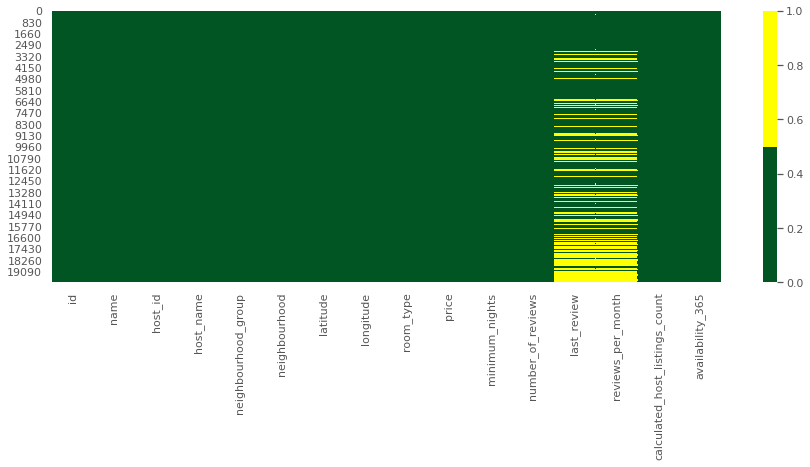

In [11]:
cols = df.columns
colours = ['#005522', '#ffff00']
# желтый - пропущенные данные
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours))

Диаграмма корреляции для визуального просмотра метрики корреляции между всеми возможными парами числовых переменных в данном наборе данных 

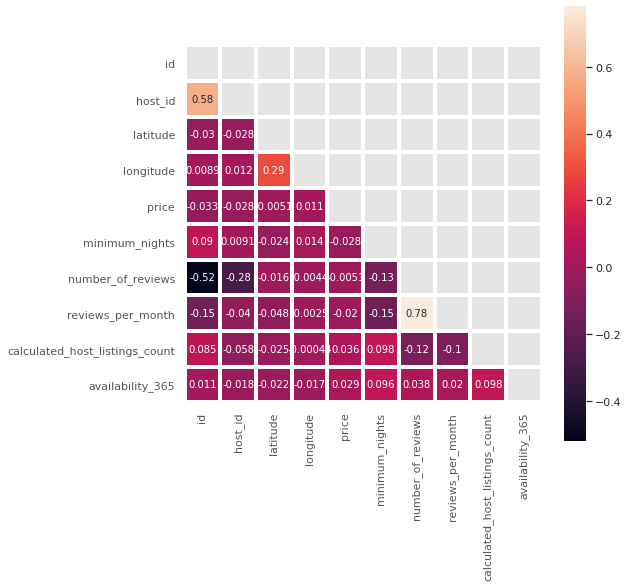

In [12]:
# матрица корреляции между атрибутами объекта
fig, ax = plt.subplots(figsize=(8, 8))
corr = df[[
    'id', 'host_id', 'latitude', 'longitude', 'price', 'minimum_nights',
    'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count',
    'availability_365'
]].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("dark"):
    ax = sns.heatmap(corr,
                     mask=mask,
                     square=True,
                     cbar=True,
                     annot=True,
                     linewidths=3)

In [13]:
#фильтр по пустым ячейкам в столбце reviews_per_month
filtered_nullable = df[df['reviews_per_month'].isnull()]
len(filtered_nullable)

5877

In [14]:
#выбор 2х столбцов по заданному фильтру
filtered_nullable = filtered_nullable[[
    'number_of_reviews', 'reviews_per_month'
]]
# количество отзывов при нулевом значении параметра в месяц
filtered_nullable['number_of_reviews'].value_counts()

0    5877
Name: number_of_reviews, dtype: int64

In [15]:
# значения NAN замененны новым значением 0
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)

In [16]:
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing * 100)))

id - 0%
name - 0%
host_id - 0%
host_name - 0%
neighbourhood_group - 0%
neighbourhood - 0%
latitude - 0%
longitude - 0%
room_type - 0%
price - 0%
minimum_nights - 0%
number_of_reviews - 0%
last_review - 30%
reviews_per_month - 0%
calculated_host_listings_count - 0%
availability_365 - 0%


### Нетипичные данные (выбросы)

In [17]:
df['price'].describe()

count    19896.000000
mean        85.995074
std        207.216127
min          0.000000
25%         34.000000
50%         54.000000
75%         93.000000
max      10000.000000
Name: price, dtype: float64

In [18]:
df['price'].median()

54.0

In [19]:
df['price'].mode()[0]

50

In [20]:
# исключение нулевого значения из набора данных
df = df[df['price'] > 0]

array([[<AxesSubplot:title={'center':'id'}>,
        <AxesSubplot:title={'center':'host_id'}>,
        <AxesSubplot:title={'center':'latitude'}>],
       [<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'minimum_nights'}>],
       [<AxesSubplot:title={'center':'number_of_reviews'}>,
        <AxesSubplot:title={'center':'reviews_per_month'}>,
        <AxesSubplot:title={'center':'calculated_host_listings_count'}>],
       [<AxesSubplot:title={'center':'availability_365'}>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

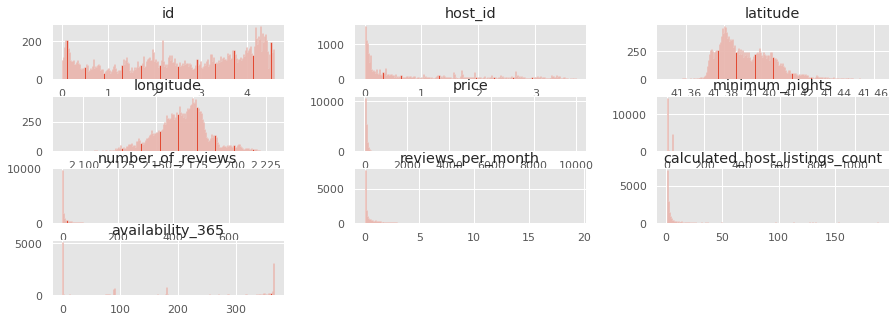

In [21]:
# гистограмма
df.hist(bins=200)

Отрицательно-биномиальное распределение значений параметра price

<AxesSubplot:>

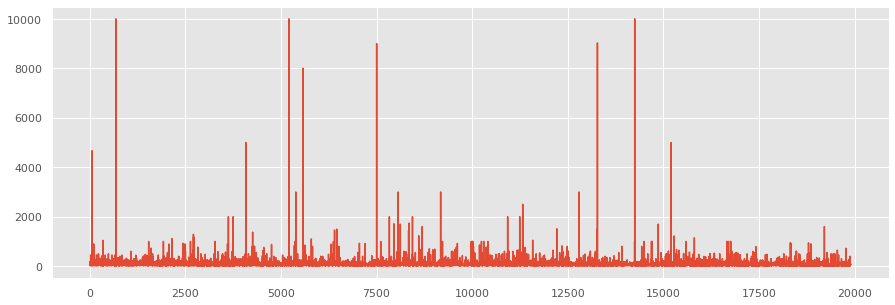

In [22]:
df["price"].plot()

/home/kate/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='price'>

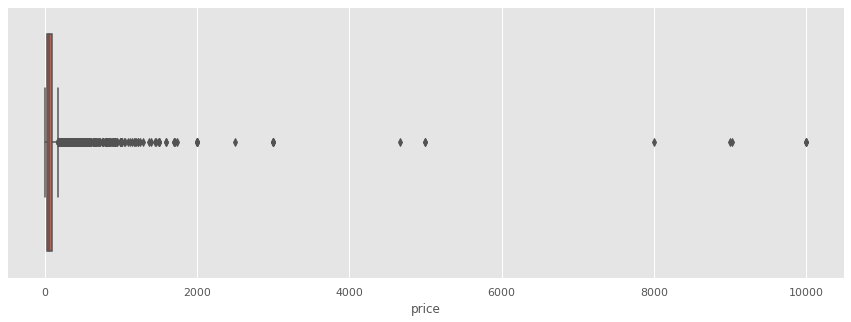

In [23]:
sns.boxplot(df['price'], orient="h")

In [24]:
# Объем нетипичных данных параметра price

df_price = df['price']
upper_quartile = np.percentile(df_price, 75)
lower_quartile = np.percentile(df_price, 25)
iqr = upper_quartile - lower_quartile  #Межквартильный диапазон
upper_whisker = df_price[df_price <= upper_quartile +
                         1.5 * iqr].max()  #1.5 межквартильных диапазона

filtered_emissions = df[
    df['price'] >
    upper_whisker]  #выборка данных с нетипичными значениями стоимости

len(filtered_emissions) / len(
    df
) * 100  #процент нетипичных значений стоимости в генеральной совокупности

7.031917567227946

In [25]:
filtered_emissions["minimum_nights"].value_counts()

1      544
3      288
2      260
30      64
32      60
4       48
5       25
7       19
6       16
14      16
28      14
31      13
15       4
150      4
60       3
90       3
33       2
360      2
34       2
180      2
29       1
135      1
18       1
36       1
12       1
10       1
100      1
120      1
240      1
365      1
Name: minimum_nights, dtype: int64

In [26]:
len(filtered_emissions[filtered_emissions["minimum_nights"] > 29]) / len(
    filtered_emissions) * 100
#процент длительной аренды (от месяца до года) в выборке нетипичной стоимости

11.508220157255183

In [27]:
# Разные регистры символов
df['name'] = df['name'].str.lower()  #нижний регистр для всех строк
filtered_emissions['name'] = filtered_emissions['name'].str.lower(
)  #нижний регистр для всех строк
df['name'] = df['name'].str.strip()  #удаление символов в начале и конце строки
df['name'] = df['name'].str.replace('\\.', '')  #удаление точек
df['name'] = df['name'].str.replace('\\bstreet\\b',
                                    'st')  # введение сокращения

<ipython-input-27-c8088e78f78a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_emissions['name'] = filtered_emissions['name'].str.lower(


In [28]:
# Поиск наиболее часто встречающихся слов в столбце name генеральной совокупности
Counter(" ".join(df["name"]).split()).most_common(10)

[('in', 4725),
 ('room', 4526),
 ('apartment', 3504),
 ('barcelona', 2608),
 ('with', 2213),
 ('the', 2109),
 ('habitación', 1871),
 ('en', 1791),
 ('-', 1671),
 ('de', 1640)]

In [29]:
# Поиск наиболее часто встречающихся слов в столбце name filtered_emissions
Counter(" ".join(filtered_emissions["name"]).split()).most_common(10)

[('apartment', 352),
 ('in', 293),
 ('with', 197),
 ('barcelona', 176),
 ('the', 161),
 ('luxury', 108),
 ('de', 107),
 ('-', 101),
 ('room', 99),
 ('terrace', 96)]

In [30]:
# процент предложений с указанием атрибута Lux в генеральной совокупности
df_lux = df[df["name"].str.contains(r'lux*')]
len(df_lux) / len(df) * 100

7.454134204574013

In [31]:
# стандартное отклонение выборки с атрибутом lux
df_lux['price'].std()

378.4141330497012

In [32]:
# процент предложений с указанием атрибута Lux в выборке нетипичной стоимости
df_lux_emission = filtered_emissions[filtered_emissions["name"].str.contains(
    r'lux*')]
len(df_lux_emission) / len(filtered_emissions) * 100

18.799142244460327

In [33]:
# процент краткосрочной аренды с указанием атрибута Lux в выборке нетипичной стоимости
df_lux_emission_short = df_lux_emission[df_lux_emission["minimum_nights"] < 29]
len(df_lux_emission_short) / len(filtered_emissions) * 100

15.511079342387418

In [34]:
df['number_of_reviews'].describe()

count    19895.000000
mean        32.144861
std         63.004152
min          0.000000
25%          0.000000
50%          4.000000
75%         34.000000
max        761.000000
Name: number_of_reviews, dtype: float64

/home/kate/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='minimum_nights'>

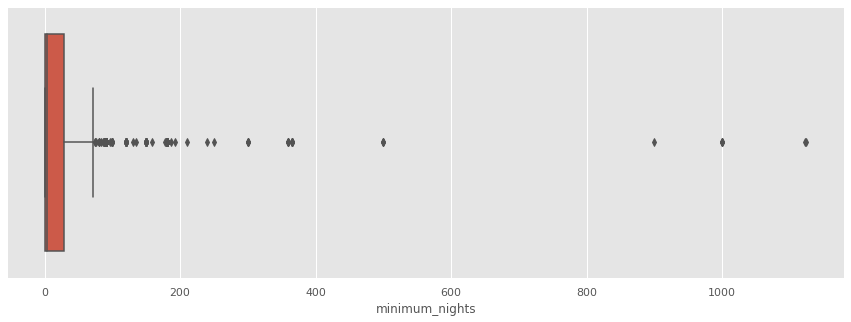

In [35]:
sns.boxplot(df['minimum_nights'], orient="h")

<AxesSubplot:>

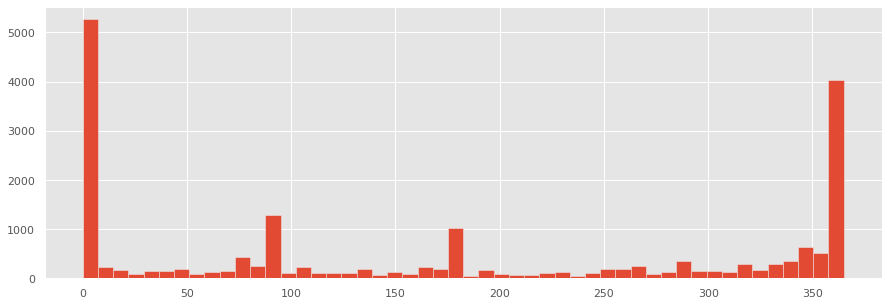

In [36]:
df['availability_365'].hist(bins=50)

In [37]:
# Группировка стоимости price_class
price_class = {}

price_category = 1

max_price = df['price'].max() + 1

first_quartile = np.percentile(df.price, 25)
second_quartile = np.percentile(df.price, 50)
third_quartile = np.percentile(df.price, 75)
fourth_quartile = upper_whisker
premium = df['price'].max()

for price in range(1, max_price):

    if (price <= first_quartile):
        price_category = 1

    elif (price > first_quartile and price <= second_quartile):
        price_category = 2

    elif (price > second_quartile and price <= third_quartile):
        price_category = 3

    elif (price > third_quartile and price <= fourth_quartile):
        price_category = 4

    elif (price > fourth_quartile and price <= premium):
        price_category = 5

    price_class[price] = price_category

price_class

{1: 1,
 2: 1,
 3: 1,
 4: 1,
 5: 1,
 6: 1,
 7: 1,
 8: 1,
 9: 1,
 10: 1,
 11: 1,
 12: 1,
 13: 1,
 14: 1,
 15: 1,
 16: 1,
 17: 1,
 18: 1,
 19: 1,
 20: 1,
 21: 1,
 22: 1,
 23: 1,
 24: 1,
 25: 1,
 26: 1,
 27: 1,
 28: 1,
 29: 1,
 30: 1,
 31: 1,
 32: 1,
 33: 1,
 34: 1,
 35: 2,
 36: 2,
 37: 2,
 38: 2,
 39: 2,
 40: 2,
 41: 2,
 42: 2,
 43: 2,
 44: 2,
 45: 2,
 46: 2,
 47: 2,
 48: 2,
 49: 2,
 50: 2,
 51: 2,
 52: 2,
 53: 2,
 54: 2,
 55: 3,
 56: 3,
 57: 3,
 58: 3,
 59: 3,
 60: 3,
 61: 3,
 62: 3,
 63: 3,
 64: 3,
 65: 3,
 66: 3,
 67: 3,
 68: 3,
 69: 3,
 70: 3,
 71: 3,
 72: 3,
 73: 3,
 74: 3,
 75: 3,
 76: 3,
 77: 3,
 78: 3,
 79: 3,
 80: 3,
 81: 3,
 82: 3,
 83: 3,
 84: 3,
 85: 3,
 86: 3,
 87: 3,
 88: 3,
 89: 3,
 90: 3,
 91: 3,
 92: 3,
 93: 3,
 94: 4,
 95: 4,
 96: 4,
 97: 4,
 98: 4,
 99: 4,
 100: 4,
 101: 4,
 102: 4,
 103: 4,
 104: 4,
 105: 4,
 106: 4,
 107: 4,
 108: 4,
 109: 4,
 110: 4,
 111: 4,
 112: 4,
 113: 4,
 114: 4,
 115: 4,
 116: 4,
 117: 4,
 118: 4,
 119: 4,
 120: 4,
 121: 4,
 122: 4,
 123: 4,
 

In [38]:
# Добавление столбца с номинативными данными категорий стоимости
df['price_class'] = df["price"].map(price_class)

In [39]:
# Группировка по длительности аренды
minimum_nights_class = {}

minimum_nights_category = 1

max_count_nights = df['minimum_nights'].max() + 1

for minimum_nights in range(1, max_count_nights):

    if (minimum_nights < 30):
        minimum_nights_category = 'short_term_rent'

    elif (minimum_nights >= 30):
        minimum_nights_category = 'long_term_rent'

    minimum_nights_class[minimum_nights] = minimum_nights_category

minimum_nights_class

{1: 'short_term_rent',
 2: 'short_term_rent',
 3: 'short_term_rent',
 4: 'short_term_rent',
 5: 'short_term_rent',
 6: 'short_term_rent',
 7: 'short_term_rent',
 8: 'short_term_rent',
 9: 'short_term_rent',
 10: 'short_term_rent',
 11: 'short_term_rent',
 12: 'short_term_rent',
 13: 'short_term_rent',
 14: 'short_term_rent',
 15: 'short_term_rent',
 16: 'short_term_rent',
 17: 'short_term_rent',
 18: 'short_term_rent',
 19: 'short_term_rent',
 20: 'short_term_rent',
 21: 'short_term_rent',
 22: 'short_term_rent',
 23: 'short_term_rent',
 24: 'short_term_rent',
 25: 'short_term_rent',
 26: 'short_term_rent',
 27: 'short_term_rent',
 28: 'short_term_rent',
 29: 'short_term_rent',
 30: 'long_term_rent',
 31: 'long_term_rent',
 32: 'long_term_rent',
 33: 'long_term_rent',
 34: 'long_term_rent',
 35: 'long_term_rent',
 36: 'long_term_rent',
 37: 'long_term_rent',
 38: 'long_term_rent',
 39: 'long_term_rent',
 40: 'long_term_rent',
 41: 'long_term_rent',
 42: 'long_term_rent',
 43: 'long_ter

In [40]:
# Добавление столбца с номинативными данными категорий длительности аренды
df['minimum_nights_class'] = df["minimum_nights"].map(minimum_nights_class)

In [41]:
# среднее количество отзывов
df['number_of_reviews'].mean()

32.14486051771802

In [42]:
df['number_of_reviews'].max()

761

In [43]:
# Группировка по количеству отзывов
number_of_reviews_class = {0: 'no_reviews'}

rank = df['number_of_reviews'].mean()
max_count_review = df['number_of_reviews'].max() + 1

for number_of_reviews in range(1, max_count_review):

    if (number_of_reviews < rank):
        number_of_reviews_category = 'few reviews'

    elif (number_of_reviews >= rank):
        number_of_reviews_category = 'many reviews'

    number_of_reviews_class[number_of_reviews] = number_of_reviews_category

number_of_reviews_class

{0: 'no_reviews',
 1: 'few reviews',
 2: 'few reviews',
 3: 'few reviews',
 4: 'few reviews',
 5: 'few reviews',
 6: 'few reviews',
 7: 'few reviews',
 8: 'few reviews',
 9: 'few reviews',
 10: 'few reviews',
 11: 'few reviews',
 12: 'few reviews',
 13: 'few reviews',
 14: 'few reviews',
 15: 'few reviews',
 16: 'few reviews',
 17: 'few reviews',
 18: 'few reviews',
 19: 'few reviews',
 20: 'few reviews',
 21: 'few reviews',
 22: 'few reviews',
 23: 'few reviews',
 24: 'few reviews',
 25: 'few reviews',
 26: 'few reviews',
 27: 'few reviews',
 28: 'few reviews',
 29: 'few reviews',
 30: 'few reviews',
 31: 'few reviews',
 32: 'few reviews',
 33: 'many reviews',
 34: 'many reviews',
 35: 'many reviews',
 36: 'many reviews',
 37: 'many reviews',
 38: 'many reviews',
 39: 'many reviews',
 40: 'many reviews',
 41: 'many reviews',
 42: 'many reviews',
 43: 'many reviews',
 44: 'many reviews',
 45: 'many reviews',
 46: 'many reviews',
 47: 'many reviews',
 48: 'many reviews',
 49: 'many revi

In [44]:
# Добавление столбца с номинативными данными категорий отзывов
df['number_of_reviews_class'] = df['number_of_reviews'].map(
    number_of_reviews_class)

In [56]:
df.pivot_table(values=['price'],
               index=[
                   'room_type', 'minimum_nights_class', 'price_class','number_of_reviews_class'
               ])

price
room_type       minimum_nights_class price_class number_of_reviews_class            
Entire home/apt long_term_rent       1           few reviews               28.478070
                                                 many reviews              27.600000
                                                 no_reviews                28.593407
                                     2           few reviews               43.898858
                                                 many reviews              43.521739
...                                                                              ...
Shared room     short_term_rent      3           no_reviews                74.000000
                                     4           few reviews              107.333333
                                                 no_reviews               115.166667
                                     5           few reviews              588.333333
                                                 no_reviews               325.684211

[96 rows x 1 columns]

<AxesSubplot:>

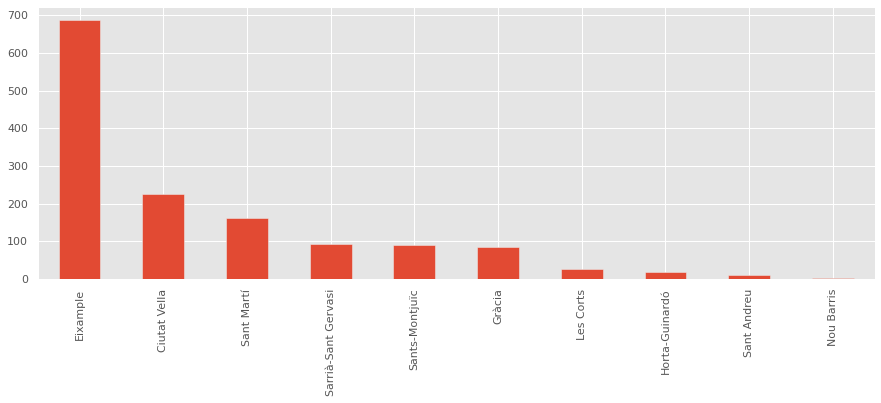

In [46]:
filtered_emissions['neighbourhood_group'].value_counts().plot.bar()

<AxesSubplot:>

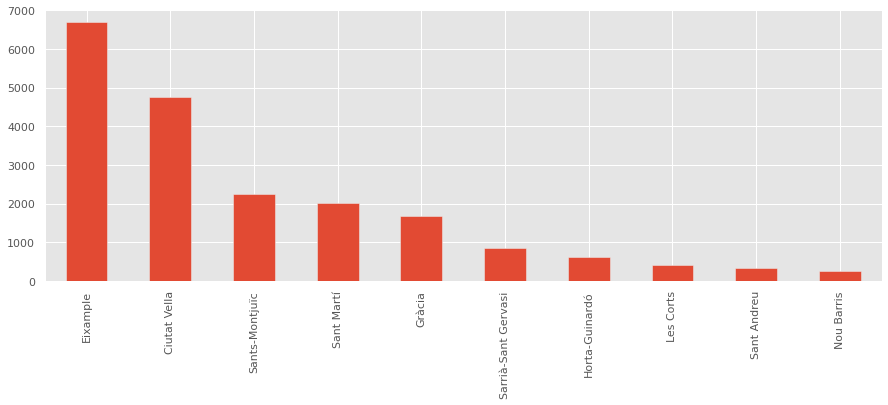

In [47]:
df['neighbourhood_group'].value_counts().plot.bar()

In [48]:
filtered_emissions['room_type'].value_counts()

Entire home/apt    1074
Private room        207
Hotel room           90
Shared room          28
Name: room_type, dtype: int64

### Качество данных 
насколько данные пригодны для использования

### Неинформативные признаки

In [49]:
[k for k, v in Counter(df["id"]).items() if v > 1]

[]

### Нерелевантные признаки

### Разные форматы данных

In [50]:
df['last_review_dt'] = pd.to_datetime(df['last_review'], format='%Y-%m-%d')

In [51]:
df.dtypes

id                                         int64
name                                      object
host_id                                    int64
host_name                                 object
neighbourhood_group                       object
neighbourhood                             object
latitude                                 float64
longitude                                float64
room_type                                 object
price                                      int64
minimum_nights                             int64
number_of_reviews                          int64
last_review                               object
reviews_per_month                        float64
calculated_host_listings_count             int64
availability_365                           int64
price_class                                int64
minimum_nights_class                      object
number_of_reviews_class                   object
last_review_dt                    datetime64[ns]
dtype: object

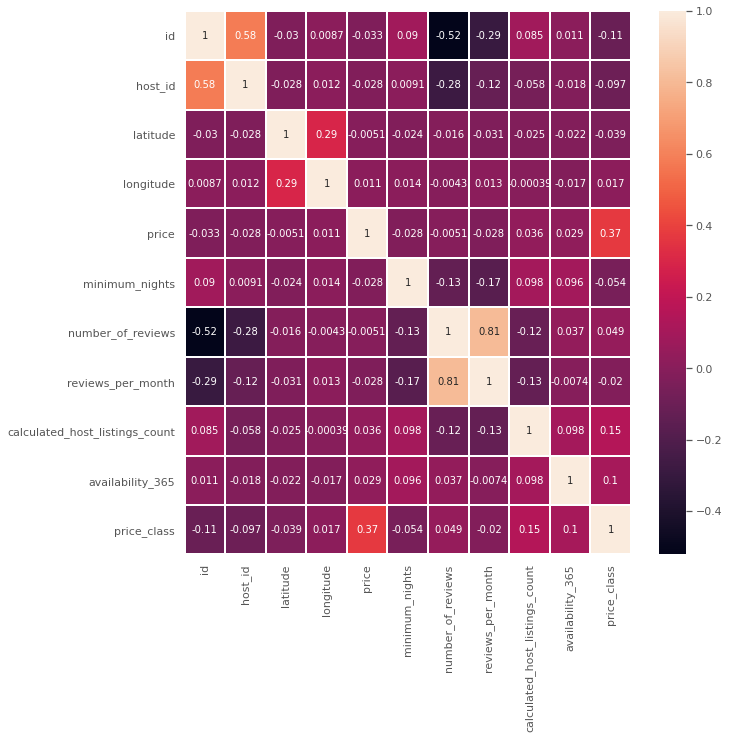

In [52]:
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df.corr(), annot=True, linewidths=1)
plt.show()

In [53]:
df.sample(5)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,price_class,minimum_nights_class,number_of_reviews_class,last_review_dt
11475,32348075,apartment central location - 1241,238859197,BBarcelona Corcega Apartments,Eixample,l'Antiga Esquerra de l'Eixample,41.39157,2.15266,Entire home/apt,93,3,0,NaN,0.00,4,262,3,short_term_rent,no_reviews,NaT
2334,5181660,#mwc rambla boqueria charming 1br,1435464,Jaume,Ciutat Vella,el Barri Gòtic,41.38284,2.17204,Entire home/apt,84,32,27,2019-07-04,0.40,21,179,3,long_term_rent,few reviews,2019-07-04
14582,38773796,charming 2 br apartment with terrace in gracia,130223809,Daiga,Gràcia,la Vila de Gràcia,41.40030,2.15167,Entire home/apt,45,32,1,2019-12-01,0.09,14,161,2,long_term_rent,few reviews,2019-12-01
8131,23152630,ab apartment paseo del born - ref gi2139,170716140,Robbie&Kay,Ciutat Vella,"Sant Pere, Santa Caterina i la Ribera",41.38424,2.18355,Entire home/apt,100,32,0,NaN,0.00,188,346,4,long_term_rent,no_reviews,NaT
12938,35627835,double room balcony,266193111,Adriana De Plaza Goya Rooms,Eixample,Sant Antoni,41.38347,2.16323,Hotel room,59,1,3,2020-03-11,0.33,10,364,3,short_term_rent,few reviews,2020-03-11


In [54]:
# import pandas_profiling
# df.profile_report();